In [ ]:
!pip install large_image
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install libtiff openslide_python pyvips gdal mapnik pyproj glymur -f https://girder.github.io/large_image_wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 KB 1.1 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get

In [ ]:
pip install python-bioformats

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

# With Bio-formats, for reading stacks

In [46]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

In [47]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.pyplot import figure
from skimage import data, exposure, img_as_float
from skimage.exposure import match_histograms, rescale_intensity
from skimage.io import imshow, imread
from skimage.draw import circle_perimeter
import cv2
import bioformats.formatreader as F
import random
import pandas as pd
from collections import defaultdict
import pickle
from scipy import ndimage, signal

%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['image.cmap'] = 'gray'

In [48]:
def img_read(self, x=0, y=0, z=0, width=1000, height=1000):
    img_path = self
    with bioformats.ImageReader(img_path) as f:
        img = f.read(XYWH=(x, y, width, height),z=z, rescale=False)

    return img
    # plt.imshow(img)

In [49]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

In [178]:
# ndpi image

ndpi_dir = '/content/gdrive/MyDrive/ENSO_project/01_data/01_ndpi/images'

images = os.listdir(ndpi_dir) 
cur_img = images[9]
img_path = os.path.join(ndpi_dir, cur_img)
print(cur_img)

PAL1999_B2_sample130_slide1 - 2023-01-19 00.35.32.ndpi


In [179]:
# ndpi annotations

ndpi_annot_dir = '/content/gdrive/MyDrive/ENSO_project/01_data/01_ndpi/annot_csv'

cur_img_basename = os.path.splitext(cur_img)[0]
annot_path = os.path.join(ndpi_annot_dir, cur_img_basename + '.csv')
# full_annot_path = os.path.join(ndpi_annot_dir, 'full_annot.csv')

In [180]:
# create list from annotations

df = pd.read_csv(annot_path, encoding= 'unicode_escape')
annot_dict = df.to_dict()

annot_list = []
crop_list = []

for i in range(len(annot_dict['Annotation X (pixels)'])):
  label = (annot_dict['Title'][i])
  x_center = (annot_dict['Annotation X (pixels)'][i])
  y_center = (annot_dict['Annotation Y (pixels)'][i])
  x_start = x_center - 512
  y_start = y_center - 512
  r = (annot_dict['Length (µm)'][i])
  if (annot_dict['Type Name'][i]) == 'Rectangle':
    crop_list.append((x_start,y_start))
  if (annot_dict['Type Name'][i]) == 'Circle':
    annot_list.append([x_start,y_start,x_center,y_center,r,label])

print(annot_list)
print(len(annot_list))
print(len(crop_list))

[[68043, 38188, 68555, 38700, 19.958, 'poa'], [11832, 13666, 12344, 14178, 15.874, 'aln'], [18188, 17033, 18700, 17545, 10.485, 'aca'], [25219, 41436, 25731, 41948, 9.304, 'mel'], [15520, 48743, 16032, 49255, 19.143, 'api'], [17260, 48898, 17772, 49410, 10.724, 'alc'], [17919, 47234, 18431, 47746, 19.713, 'dra'], [26381, 48788, 26893, 49300, 13.155, 'ind_u'], [21963, 52115, 22475, 52627, 11.321, 'u_m'], [22262, 52369, 22774, 52881, 15.086, 'ast'], [12189, 63861, 12701, 64373, 15.807, 'eri'], [122309, 53233, 122821, 53745, 11.486, 'cle'], [99458, 15624, 99970, 16136, 13.657, 'ind_u'], [107309, 5175, 107821, 5687, 13.817, 'myr'], [106965, 3847, 107477, 4359, 23.109, 'cyp'], [116506, 9414, 117018, 9926, 11.216, 'cle'], [68280, 62349, 68792, 62861, 18.129, 'myr'], [17177, 49114, 17689, 49626, 14.059, 'aln'], [17523, 48981, 18035, 49493, 19.662, 'lyc'], [106326, 3997, 106838, 4509, 13.201, 'aln'], [85100, 53800, 85612, 54312, 16.435, 'pla'], [64945, 38114, 65457, 38626, 26.357, 'iso'], [634

In [181]:
# get metadata
omexml = bioformats.get_omexml_metadata(img_path)
b = bioformats.OMEXML(xml=omexml)

metadata = {}
calibration = b.image().Pixels.PhysicalSizeX
calibration_unit = b.image().Pixels.PhysicalSizeXUnit
width = b.image().Pixels.SizeX
height = b.image().Pixels.SizeY
zPlane = b.image().Pixels.SizeZ

metadata.update({'calibration': calibration})
metadata.update({'calibration_unit': calibration_unit})
metadata.update({'width': width})
metadata.update({'height': height})
metadata.update({'zPlane': zPlane})
print(metadata)

{'calibration': 0.22507314877335133, 'calibration_unit': 'µm', 'width': 142848, 'height': 96256, 'zPlane': 9}


In [182]:
# # Create a list of all tiles
width = 1024
height = 1024

full_start_xy_list = crop_list
print(crop_list)

# full_start_x_list = np.arange(400, metadata['width'] - width, width).tolist()
# full_start_y_list = np.arange(102, metadata['height'] - height, height).tolist()

# full_start_xy_list = []
# for i in range(len(full_start_x_list)):
#   for j in range(len(full_start_y_list)):
#     x = full_start_x_list[i]
#     y = full_start_y_list[j]
#     xy = (x,y)
#     full_start_xy_list.append(xy)
# print(len(full_start_xy_list))
# print(full_start_xy_list)

[(84196, 74695), (11851, 63450), (15726, 49004), (17312, 49016), (17835, 47109), (6524, 37923), (7555, 38913), (10625, 37907), (12667, 37918), (12660, 38931), (15729, 37913), (16610, 38824), (16756, 39827), (15732, 39948), (17775, 37910), (18796, 37908), (19811, 37907), (20832, 37905), (23902, 37908), (25834, 37978), (32089, 37903), (34116, 37910), (36169, 38001), (37680, 38806), (41279, 39951), (42305, 37904), (43326, 37902), (45362, 38926), (48799, 37906), (54562, 37912), (56599, 37913), (58652, 37914), (60691, 37907), (61710, 37905), (63756, 37909), (64771, 37899), (67847, 37984), (69895, 37914), (70912, 38018), (71930, 38284), (75594, 37903), (75121, 38927), (77040, 37915), (79864, 38927), (81129, 37899), (82161, 37901), (84195, 37900), (89309, 38923), (94416, 37902), (95446, 38929), (103613, 37917), (104640, 37910), (110975, 38622), (113449, 37911), (116947, 38737), (127117, 38484), (122000, 53234), (119333, 58107), (85215, 54260), (68147, 62675), (97024, 10579), (107688, 5207), (

In [183]:
# create a dictionary, with the tile upper left coordinates as the key and values as [label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r]
tiles_dict = defaultdict(list)
for i in range(len(full_start_xy_list)):
  x = full_start_xy_list[i][0]
  y = full_start_xy_list[i][1]
  key = (x,y)
  for j in range(len(annot_list)):
    annot = annot_list[j]
    abs_x_center = annot[2]
    abs_y_center = annot[3]
    if abs_x_center in range(x, x+1024) and abs_y_center in range(y, y+1024):
      rel_x_center = abs_x_center - x
      rel_y_center = abs_y_center - y
      r = annot[4]
      r = round(r/metadata['calibration'])
      label = annot[5]
      tiles_dict[key].append([label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r])
      # tiles_dict.update({key:[abs_x_center, abs_y_center, rel_x_center,rel_y_center, r, label]})

print(tiles_dict)

defaultdict(<class 'list'>, {(84196, 74695): [['ind_u', 84957, 75540, 761, 845, 64]], (11851, 63450): [['eri', 12701, 64373, 850, 923, 70]], (15726, 49004): [['api', 16032, 49255, 306, 251, 85]], (17312, 49016): [['alc', 17772, 49410, 460, 394, 48], ['aln', 17689, 49626, 377, 610, 62], ['lyc', 18035, 49493, 723, 477, 87]], (17835, 47109): [['dra', 18431, 47746, 596, 637, 88]], (6524, 37923): [['u_m', 7403, 38282, 879, 359, 46], ['lyc', 6645, 38621, 121, 698, 94]], (7555, 38913): [['iso', 7711, 39052, 156, 139, 122]], (10625, 37907): [['iso', 10862, 38247, 237, 340, 122]], (12667, 37918): [['iso', 13021, 38757, 354, 839, 127]], (12660, 38931): [['aln', 12999, 39136, 339, 205, 49]], (15729, 37913): [['hup', 15815, 38811, 86, 898, 112]], (16610, 38824): [['poa', 17445, 39029, 835, 205, 117], ['iso', 16752, 39063, 142, 239, 123], ['iso', 16897, 39691, 287, 867, 133]], (16756, 39827): [['pod', 17231, 39985, 475, 158, 158]], (15732, 39948): [['jug', 16400, 40616, 668, 668, 82], ['ply', 16436

In [184]:
for i in range(len(list(tiles_dict.keys()))):
  key = list(tiles_dict.keys())[i]
  annot = tiles_dict[key]
  print(i, key, annot)

0 (84196, 74695) [['ind_u', 84957, 75540, 761, 845, 64]]
1 (11851, 63450) [['eri', 12701, 64373, 850, 923, 70]]
2 (15726, 49004) [['api', 16032, 49255, 306, 251, 85]]
3 (17312, 49016) [['alc', 17772, 49410, 460, 394, 48], ['aln', 17689, 49626, 377, 610, 62], ['lyc', 18035, 49493, 723, 477, 87]]
4 (17835, 47109) [['dra', 18431, 47746, 596, 637, 88]]
5 (6524, 37923) [['u_m', 7403, 38282, 879, 359, 46], ['lyc', 6645, 38621, 121, 698, 94]]
6 (7555, 38913) [['iso', 7711, 39052, 156, 139, 122]]
7 (10625, 37907) [['iso', 10862, 38247, 237, 340, 122]]
8 (12667, 37918) [['iso', 13021, 38757, 354, 839, 127]]
9 (12660, 38931) [['aln', 12999, 39136, 339, 205, 49]]
10 (15729, 37913) [['hup', 15815, 38811, 86, 898, 112]]
11 (16610, 38824) [['poa', 17445, 39029, 835, 205, 117], ['iso', 16752, 39063, 142, 239, 123], ['iso', 16897, 39691, 287, 867, 133]]
12 (16756, 39827) [['pod', 17231, 39985, 475, 158, 158]]
13 (15732, 39948) [['jug', 16400, 40616, 668, 668, 82], ['ply', 16436, 40274, 704, 326, 84]]


# Visualize images with masks

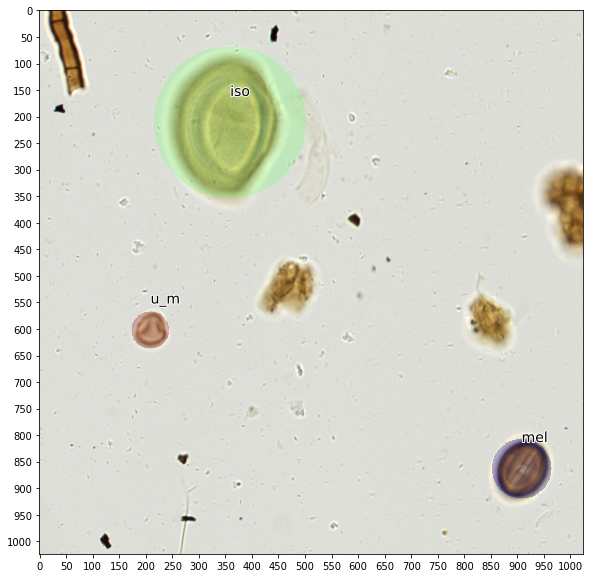

In [86]:
# show image with annotation

# x,y = random.choice(start_xy_list)

idx = 0
cur_tile_key = list(tiles_dict)[idx]
x_start = cur_tile_key[0]
y_start = cur_tile_key[1]
annot = tiles_dict[cur_tile_key]
detMask = np.zeros((width,height))

img = img_read(img_path, x=x_start, y=y_start, z=4, width = width, height = height).astype(np.float64)

img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img = img.astype(np.uint8)

for i in range(len(annot)):
  cur_annot = annot[i]
  x = cur_annot[3]
  y = cur_annot[4]
  r = cur_annot[5]
  label = cur_annot[0]
  detMask = create_circular_mask(detMask, [y, x], r, value=i+1)
  plt.text(x, y-50, label,
          fontsize=14,
          color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])

plt.xticks(np.arange(0, height+1, 50))
plt.yticks(np.arange(0, height+1, 50))
# plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "-.")
masked = np.ma.masked_where(detMask == 0, detMask)
plt.imshow(img) 
plt.imshow(masked, 'jet', interpolation='none', alpha=0.3)  

In [ ]:
# # save the dictionary
# save_dir = '/content/gdrive/MyDrive/ENSO_project/01_data/03_annot'
# slide = cur_img_basename.split(' -')[0]

# if not os.path.exists(os.path.join(save_dir, slide)):
#   os.makedirs(os.path.join(save_dir, slide))

# with open(os.path.join(save_dir,slide,'annot_dict.pkl'), 'wb') as handle:
#     pickle.dump(tiles_dict,handle)    

In [ ]:
# # save annotation as a pkl file
# tile_name = str(x_start)+'x_'+str(y_start)+'y'

# with open(os.path.join(save_dir,slide,tile_name+'.pkl'), 'wb') as handle:
#     pickle.dump(annot,handle)      

In [ ]:
# # check dictionary
# with open(os.path.join(save_dir,slide,'annot_dict.pkl'), 'rb') as handle:
#     tiles_dict = pickle.load(handle) 

In [ ]:
# # check annotation pkl file
# with open(os.path.join(save_dir,slide,tile_name+'.pkl'), 'rb') as handle:
#     annot = pickle.load(handle) 
# print(annot)

# Loop through and export crops

In [ ]:
# Loop through and crop tiles, export images
# Create new folder for crops with subfolders for each stack. 

In [ ]:
slide = cur_img_basename.split(' -')[0]
slide

'PAL1999_C3_sample67_slide1'

In [ ]:
# img_name = os.path.basename(img_path).split(' ')[0]
# core_name = img_path.split('/')[-2].split('_')[0]
crops_dir = os.path.join('/content/gdrive/MyDrive/ENSO_project/01_data/02_tiles', slide)
if not os.path.exists(crops_dir): 
    os.makedirs(crops_dir)
# print(img_name)
# print(core_name)
print(crops_dir)

/content/gdrive/MyDrive/ENSO_project/01_data/02_tiles/PAL1999_C3_sample67_slide1


In [ ]:
width = 1024
height = 1024
iterCount = 0

for i in range(len(list(tiles_dict.keys()))):
    iterCount += 1

    cur_tile_key = list(tiles_dict.keys())[i]
    start_x = cur_tile_key[0]
    start_y = cur_tile_key[1]
    tile_dir = os.path.join(crops_dir, str(start_x) + 'x_' + str(start_y) + 'y')
    # if os.path.exists(tile_dir):
    #   continue
    if not os.path.exists(tile_dir): 
      os.makedirs(tile_dir)
    for j in range(zPlane):
      img = img_read(img_path, x=start_x, y=start_y, z=j,  width = width, height = height)
      im = Image.fromarray(img)
      im.save(os.path.join(tile_dir,  str(j) + 'z.png'))
    if iterCount%10==0:
        print('{}/{}'.format(iterCount,len(list(tiles_dict.keys()))))

10/55
20/55
30/55
40/55
50/55


# Loop through and export masks, annotations

In [185]:
slide = cur_img_basename.split(' -')[0]
annot_dir = os.path.join('/content/gdrive/MyDrive/ENSO_project/01_data/03_annot', slide)
if not os.path.exists(annot_dir): 
    os.makedirs(annot_dir)
mask_dir =  os.path.join('/content/gdrive/MyDrive/ENSO_project/01_data/04_masks', slide)
if not os.path.exists(mask_dir): 
    os.makedirs(mask_dir)

In [186]:
exclude = ['non pollen','not pollen','ped','degraded','fun','ind exclude']

In [187]:
width = 1024
height = 1024
iterCount = 0

for i in range(len(list(tiles_dict.keys()))):
    iterCount += 1

    cur_tile_key = list(tiles_dict.keys())[i]
    start_x = cur_tile_key[0]
    start_y = cur_tile_key[1]
    tile_dir = os.path.join(str(start_x) + 'x_' + str(start_y) + 'y')

    annot = tiles_dict[cur_tile_key]
    detMask = np.zeros((width,height))

    for j in range(len(annot)):
      cur_annot = annot[j]
      label = cur_annot[0]
      if label in exclude:
        continue
      x = cur_annot[3]
      y = cur_annot[4]
      r = cur_annot[5]
      detMask = create_circular_mask(detMask, [y, x], r, value=j+1)

    mask_distanceTransform = ndimage.distance_transform_edt(detMask)
    mask_distanceTransform = mask_distanceTransform.astype(np.uint8)

    # # save mask
    # mask_save_dir = os.path.join(mask_dir, tile_dir)
    # if not os.path.exists(mask_save_dir): 
    #     os.makedirs(mask_save_dir)
    # im = Image.fromarray(mask_distanceTransform)
    # im.save(os.path.join(mask_save_dir,'GT_mask.png'))

    # save annot
    with open(os.path.join(annot_dir,tile_dir+'.pkl'), 'wb') as handle:
        pickle.dump(annot,handle)   

    if iterCount%10==0:
        print('{}/{}'.format(iterCount,len(list(tiles_dict.keys()))))

10/87
20/87
30/87
40/87
50/87
60/87
70/87
80/87


# check images, annotations, masks

In [164]:
import PIL.Image

In [188]:
path_to_image = '/content/gdrive/MyDrive/ENSO_project/01_data/02_tiles'
path_to_mask = '/content/gdrive/MyDrive/ENSO_project/01_data/04_masks'
path_to_annot= '/content/gdrive/MyDrive/ENSO_project/01_data/03_annot'  

In [189]:
# for i in range(len(list(tiles_dict.keys()))):
i = 4
cur_tile_key = list(tiles_dict.keys())[i]
start_x = cur_tile_key[0]
start_y = cur_tile_key[1]
tile_dir = os.path.join(str(start_x) + 'x_' + str(start_y) + 'y')
# current_example

current_image_path= os.path.join(path_to_image, slide, tile_dir)
current_distTransform_path=os.path.join(path_to_mask, slide,tile_dir)
current_annot_path = os.path.join(path_to_annot, slide ,tile_dir+'.pkl')

z = 4     # set to the desired z-plane (0, 8)
img_stack_paths = []
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      tmpImg = os.path.join(str(current_image_path), file)
      img_stack_paths.append(tmpImg)
image = PIL.Image.open(img_stack_paths[z])

for file in os.listdir(current_distTransform_path):
  if file.endswith('.png'):
    mask_distanceTransform = PIL.Image.open(os.path.join(current_distTransform_path, file))
    mask_distanceTransform=np.array(mask_distanceTransform)

with open(current_annot_path, 'rb') as handle:
    annot = pickle.load(handle) 
print(annot)

[['dra', 18431, 47746, 596, 637, 88]]


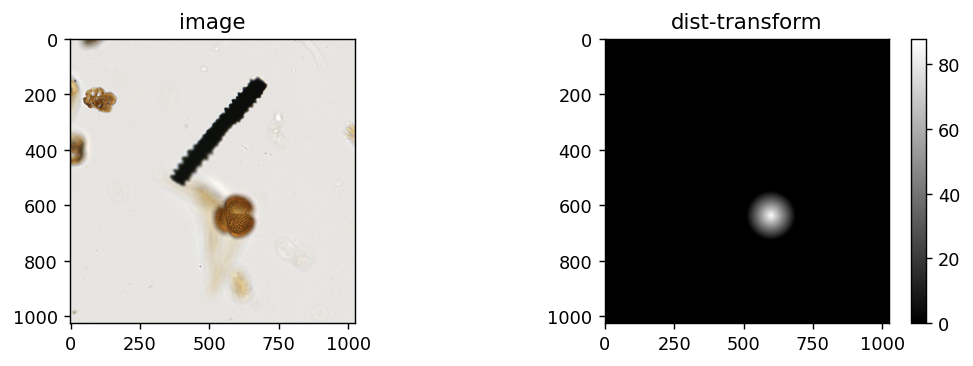

In [190]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_distanceTransform)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()

old code, possibly useful for exporting crops of all images

In [ ]:
full_start_x_list = np.arange(0, metadata['width'] - width, width).tolist()
full_start_y_list = np.arange(0, metadata['height'] - height, height).tolist()

In [ ]:
full_start_xy_list = []
for i in range(len(full_start_x_list)):
  for j in range(len(full_start_y_list)):
    x = full_start_x_list[i]
    y = full_start_y_list[j]
    xy = (x,y)
    full_start_xy_list.append(xy)
print(len(full_start_xy_list))
print(full_start_xy_list)

# num_add_random_samples = round(len(start_xy_list_2)*0.01)-len(start_xy_list)
# print(num_add_random_samples)
# print(len(start_xy_list))

# sample = random.sample(start_xy_list_2, num_add_random_samples)

In [ ]:
for i in range(len(full_start_xy_list)):
  x = full_start_xy_list[i][0]
  y = full_start_xy_list[i][1]
  if x_center in range(x, x+1024) and y_center in range(y, y+1024):
    print(i)
    print(x,y)
    break

In [ ]:
full_start_xy_list = start_xy_list + sample
print(full_start_xy_list)
print(len(full_start_xy_list))

In [ ]:
# start_x_list = np.arange(0, metadata['width'] - width, width).tolist()
# start_y_list = np.arange(0, metadata['height'] - height, height).tolist()
# start_xy_list = []

# for i in range(len(start_x_list)):
#   for j in range(len(start_y_list)):
#     x = start_x_list[i]
#     y = start_y_list[j]
#     xy = (x,y)
#     start_xy_list.append(xy)

# print(len(start_xy_list))
# sample = random.sample(start_xy_list, 350)
# print(sample)

In [ ]:
# for i in tmp_img_list:
#   start_xy_list.remove(i)

# print(len(start_xy_list))